In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
import pretty_midi
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt


In [3]:
# Step 1: Load and Parse MIDI Files
def parse_midi(file_path):
    """
    Parse a MIDI file and extract note pitches.
    Each note is represented as (start_time, end_time, pitch).
    """
    midi_data = pretty_midi.PrettyMIDI(file_path)
    notes = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            notes.append((note.start, note.end, note.pitch))
    return notes

def load_multiple_midi_files(folder_path):
    """
    Load and parse multiple MIDI files from a folder.
    """
    all_notes = []
    for file_path in tqdm(glob.glob(f"{folder_path}/*.midi"), desc="Processing MIDI files"):
        try:
            notes = parse_midi(file_path)
            all_notes.extend(notes)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    return all_notes

In [29]:
# Step 2: Preprocess Data
def preprocess_notes(notes, sequence_length=50):
    pitches = [note[2] for note in notes]
    unique_pitches = sorted(set(pitches))
    pitch_to_idx = {pitch: i for i, pitch in enumerate(unique_pitches)}
    idx_to_pitch = {i: pitch for pitch, i in pitch_to_idx.items()}
    
    encoded = [pitch_to_idx[p] for p in pitches]
    sequences = []
    targets = []
    for i in range(len(encoded) - sequence_length):
        sequences.append(encoded[i:i+sequence_length])
        targets.append(encoded[i+sequence_length])
    
    return np.array(sequences), np.array(targets), pitch_to_idx, idx_to_pitch

In [27]:
# Step 3: Define the Vanilla LSTM Model
def create_model(vocab_size, embed_size, hidden_size):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=50))
    model.add(LSTM(hidden_size))  # Single LSTM layer (Vanilla LSTM)
    model.add(Dense(vocab_size, activation='softmax'))
    return model

In [31]:
# Step 4: Train the Model
def train_model(model, sequences, targets, batch_size=64, epochs=10):
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    history = model.fit(sequences, targets, batch_size=batch_size, epochs=epochs, shuffle=True)
    return history

In [33]:
# Step 5: Generate Music
def generate_sequence(model, start_sequence, idx_to_pitch, seq_length=100):
    generated = list(start_sequence)
    input_seq = np.array(start_sequence).reshape(1, -1)
    for _ in range(seq_length):
        output = model.predict(input_seq)
        predicted = np.argmax(output, axis=1)
        generated.append(predicted[0])
        input_seq = np.append(input_seq[:, 1:], [[predicted[0]]], axis=1)
    return [idx_to_pitch[idx] for idx in generated]

In [35]:
# Step 6: Save MIDI File
def save_to_midi(sequence, output_file):
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)
    start_time = 0
    for pitch in sequence:
        note = pretty_midi.Note(velocity=100, pitch=pitch, start=start_time, end=start_time + 0.5)
        instrument.notes.append(note)
        start_time += 0.5
    midi.instruments.append(instrument)
    midi.write(output_file)

Loading MIDI files...


Processing MIDI files: 100%|██████████| 163/163 [00:16<00:00, 10.03it/s]


Preprocessing notes...
Total sequences: 612014
Creating multi-layer LSTM model...
Starting training...
Epoch 1/10


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


9563/9563 ━━━━━━━━━━━━━━━━━━━━ 235s 24ms/step - accuracy: 0.0886 - loss: 3.5077
Epoch 2/10
9563/9563 ━━━━━━━━━━━━━━━━━━━━ 237s 25ms/step - accuracy: 0.1670 - loss: 3.0933
Epoch 3/10
9563/9563 ━━━━━━━━━━━━━━━━━━━━ 258s 24ms/step - accuracy: 0.2000 - loss: 2.9743
Epoch 4/10
9563/9563 ━━━━━━━━━━━━━━━━━━━━ 225s 23ms/step - accuracy: 0.2180 - loss: 2.9076
Epoch 5/10
9563/9563 ━━━━━━━━━━━━━━━━━━━━ 226s 24ms/step - accuracy: 0.2295 - loss: 2.8599
Epoch 6/10
9563/9563 ━━━━━━━━━━━━━━━━━━━━ 226s 24ms/step - accuracy: 0.2383 - loss: 2.8299
Epoch 7/10
9563/9563 ━━━━━━━━━━━━━━━━━━━━ 227s 24ms/step - accuracy: 0.2453 - loss: 2.8022
Epoch 8/10
9563/9563 ━━━━━━━━━━━━━━━━━━━━ 229s 24ms/step - accuracy: 0.2490 - loss: 2.7854
Epoch 9/10
9563/9563 ━━━━━━━━━━━━━━━━━━━━ 283s 26ms/step - accuracy: 0.2546 - loss: 2.7673
Epoch 10/10
9563/9563 ━━━━━━━━━━━━━━━━━━━━ 249s 26ms/step - accuracy: 0.2585 - loss: 2.7499


Training completed.


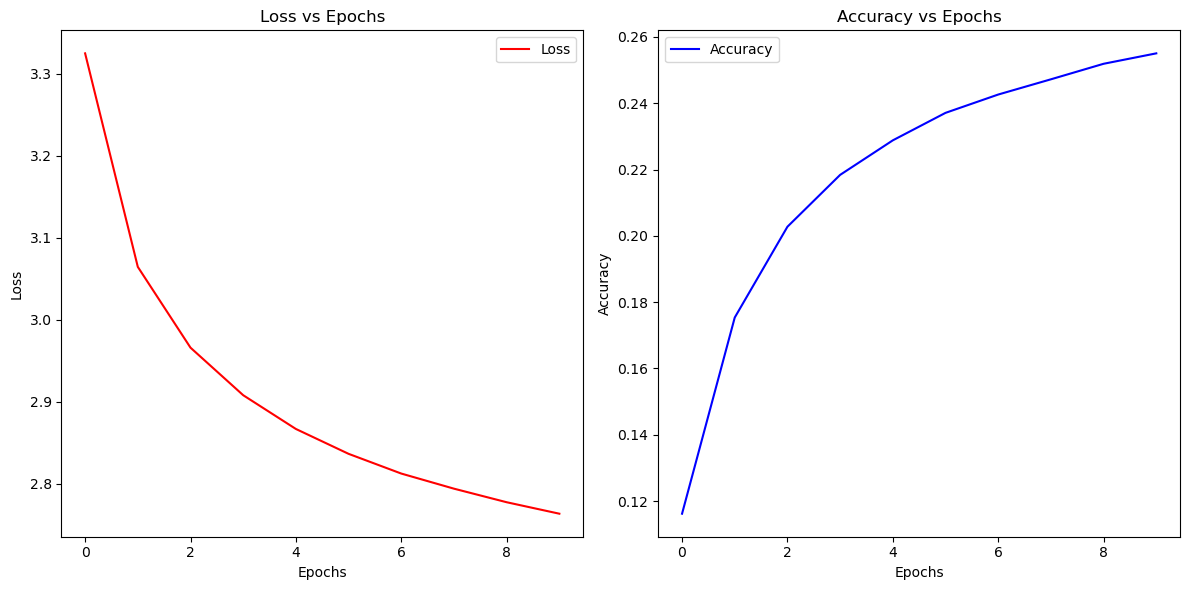

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━

In [37]:
if __name__ == "__main__":
    folder_path = 'C:/Users/HP/Downloads/train-20241205T124602Z-001/train/2011'  # Folder path containing MIDI files
    print("Loading MIDI files...")
    notes = load_multiple_midi_files(folder_path)  # Parse all files
    
    print("Preprocessing notes...")
    sequences, targets, pitch_to_idx, idx_to_pitch = preprocess_notes(notes)
    
    print(f"Total sequences: {len(sequences)}")
    
    vocab_size = len(pitch_to_idx)
    embed_size = 64
    hidden_size = 128
    num_layers = 3  # Set the number of stacked LSTM layers
    
    print("Creating multi-layer LSTM model...")
    model = create_model(vocab_size, embed_size, hidden_size)
    
    print("Starting training...")
    history = train_model(model, sequences, targets, batch_size=64, epochs=10)
    print("Training completed.")
    
    # Save the trained model (Optional)
    model.save('trained_music_multi_lstm.h5')

    # Plot loss and accuracy
    plt.figure(figsize=(12, 6))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss', color='red')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Accuracy', color='blue')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    
    # Generate and Save MIDI
    start_sequence = sequences[0]  # You can choose a different starting sequence
    generated_sequence = generate_sequence(model, start_sequence, idx_to_pitch, seq_length=100)
    save_to_midi(generated_sequence, 'generated_music.midi')
    print("Generated MIDI saved as 'generated_music.midi'.")

In [49]:
# Generate and Save MIDI
start_sequence = sequences[5]  # You can choose a different starting sequence
generated_sequence = generate_sequence(model, start_sequence, idx_to_pitch, seq_length=100)
save_to_midi(generated_sequence, 'generated_music.midi')
print("Generated MIDI saved as 'generated_music.midi'.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [51]:
# Generate and Save MIDI
start_sequence = sequences[10]  # You can choose a different starting sequence
generated_sequence = generate_sequence(model, start_sequence, idx_to_pitch, seq_length=100)
save_to_midi(generated_sequence, 'generated_music.midi')
print("Generated MIDI saved as 'generated_music.midi'.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [53]:
# Generate and Save MIDI
start_sequence = sequences[15]  # You can choose a different starting sequence
generated_sequence = generate_sequence(model, start_sequence, idx_to_pitch, seq_length=100)
save_to_midi(generated_sequence, 'generated_music.midi')
print("Generated MIDI saved as 'generated_music.midi'.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [55]:
# Generate and Save MIDI
start_sequence = sequences[20]  # You can choose a different starting sequence
generated_sequence = generate_sequence(model, start_sequence, idx_to_pitch, seq_length=100)
save_to_midi(generated_sequence, 'generated_music.midi')
print("Generated MIDI saved as 'generated_music.midi'.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

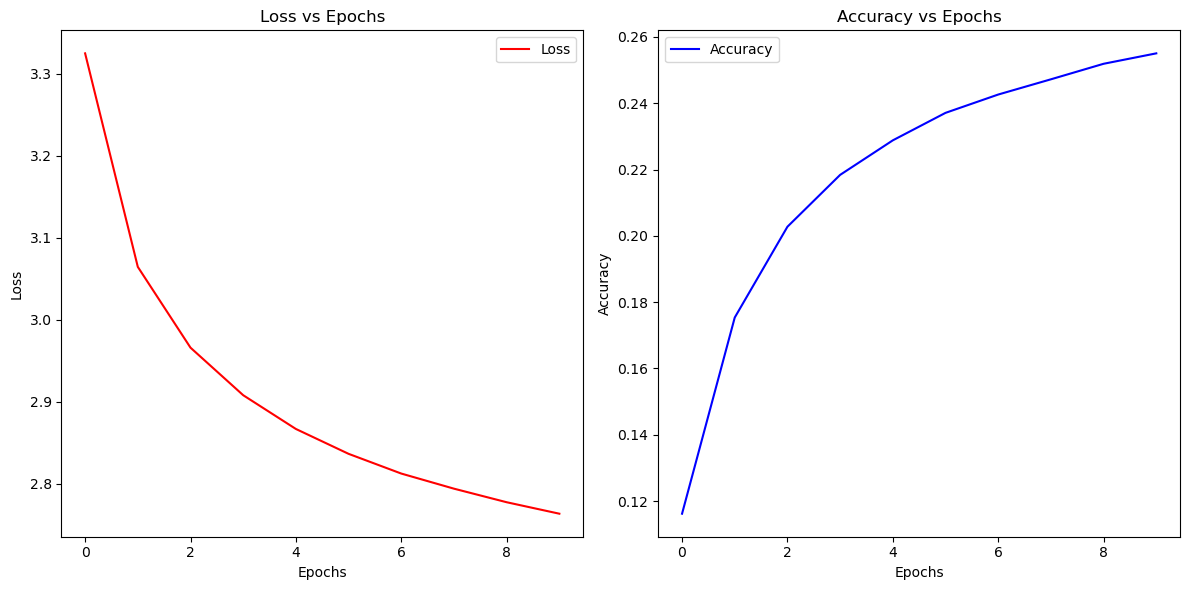

In [43]:
# Plot loss and accuracy
plt.figure(figsize=(12, 6))
    
    # Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss', color='red')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
    
    # Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy', color='blue')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 64)         │         5,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 87)             │        11,223 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,823 (1.32 MB)

 Trainable params: 115,607 (451.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 231,216 (903.19 KB)